# General Imports

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
%matplotlib inline

In [4]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from PIL import Image
from icecream import ic

In [5]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [6]:
from datasets import GtsrbModule

In [7]:
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.datamodules import STL10DataModule

In [8]:
from models import ResnetModule

In [9]:
from dropblock import DropBlock2D, LinearScheduler

In [10]:
from ls_ood_detect_cea.uncertainty_estimation import Hook
from ls_ood_detect_cea.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_dl_h_z
from ls_ood_detect_cea.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.detectors import KDEClassifier, DetectorKDE
from ls_ood_detect_cea.score import get_hz_scores
from ls_ood_detect_cea.metrics import get_hz_detector_results
from ls_ood_detect_cea.metrics import get_ood_detector_results
from ls_ood_detect_cea.metrics import plot_roc_ood_detector
from ls_ood_detect_cea.metrics import plot_auprc_ood_detector
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.dimensionality_reduction import apply_pca_ds_split
from ls_ood_detect_cea.dimensionality_reduction import apply_pca_transform

# Load Entropy Values

In [11]:
gtsrb_rn18_h_z_gtsrb_normal_train_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.npy')

In [12]:
gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.npy')

gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.npy')

gtsrb_rn18_h_z_cifar10_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_cifar10_valid_samples_np.npy')
gtsrb_rn18_h_z_cifar10_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_cifar10_test_samples_np.npy')

gtsrb_rn18_h_z_stl10_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_stl10_valid_samples_np.npy')
gtsrb_rn18_h_z_stl10_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_stl10_test_samples_np.npy')

In [13]:
ic(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_test_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_test_samples_np.shape);

ic| gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_cifar10_valid_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_cifar10_test_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_stl10_valid_samples_np.shape: (3000, 128)
ic| gtsrb_rn18_h_z_stl10_test_samples_np.shape: (8000, 128)


# Entropy 2D Projection

(7218, 128)
(7218, 1)
(7218, 2)


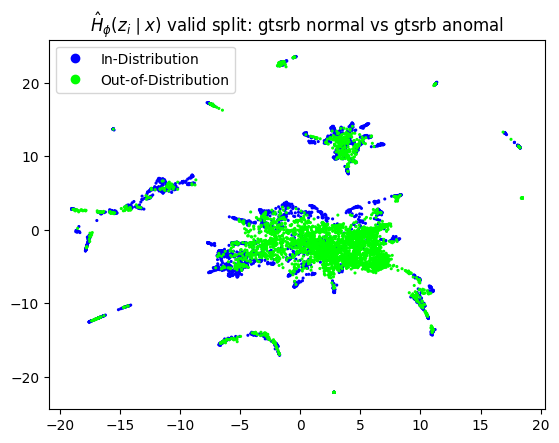

In [12]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np,
                    gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ valid split: gtsrb normal vs gtsrb anomal")

(2546, 128)
(2546, 1)
(2546, 2)


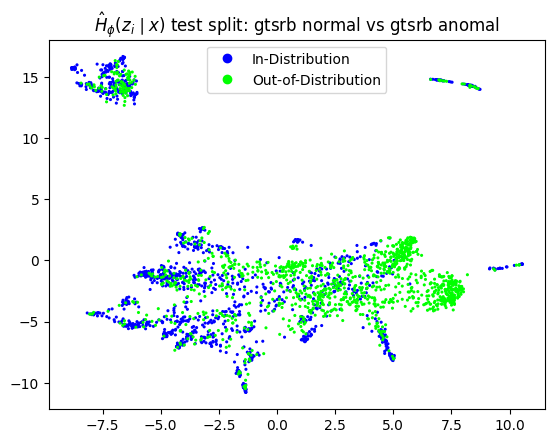

In [13]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np,
                    gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np,
                    neighbors=14,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ test split: gtsrb normal vs gtsrb anomal")

(6609, 128)
(6609, 1)
(6609, 2)


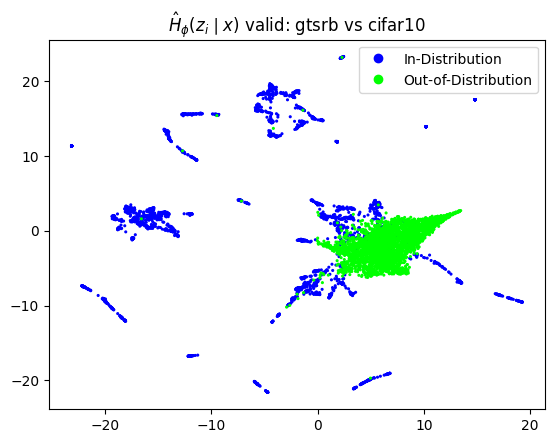

In [32]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np,
                    gtsrb_rn18_h_z_cifar10_valid_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ valid: gtsrb vs cifar10")

(6609, 128)
(6609, 1)
(6609, 2)


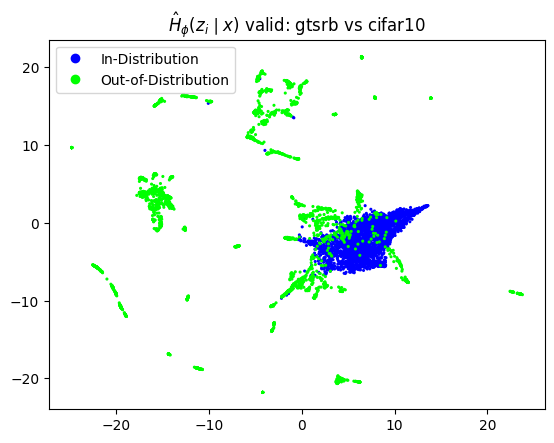

In [33]:
plot_samples_pacmap(gtsrb_rn18_h_z_cifar10_valid_samples_np,
                    gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ valid: gtsrb vs cifar10")

(4273, 128)
(4273, 1)
(4273, 2)


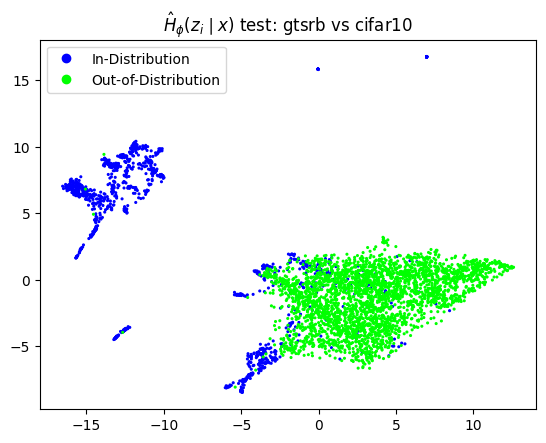

In [35]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np,
                    gtsrb_rn18_h_z_cifar10_test_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ test: gtsrb vs cifar10")

(4273, 128)
(4273, 1)
(4273, 2)


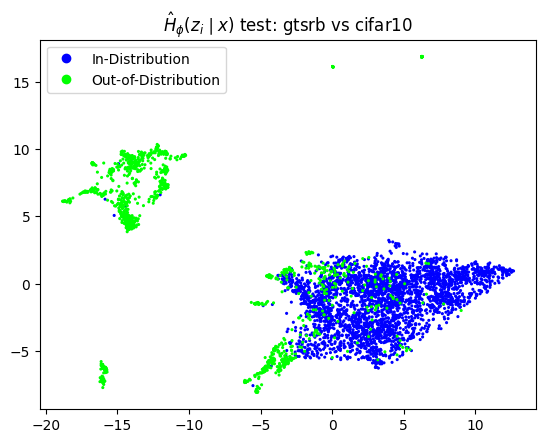

In [36]:
plot_samples_pacmap(gtsrb_rn18_h_z_cifar10_test_samples_np,
                    gtsrb_rn18_h_z_gtsrb_normal_test_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ test: gtsrb vs cifar10")

(6609, 128)
(6609, 1)
(6609, 2)


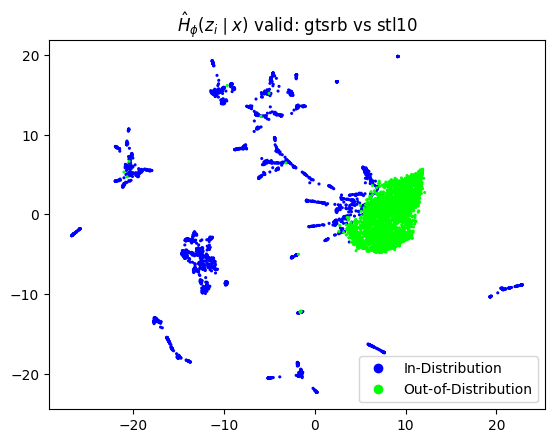

In [21]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np,
                    gtsrb_rn18_h_z_stl10_valid_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ valid: gtsrb vs stl10")

(6609, 128)
(6609, 1)
(6609, 2)


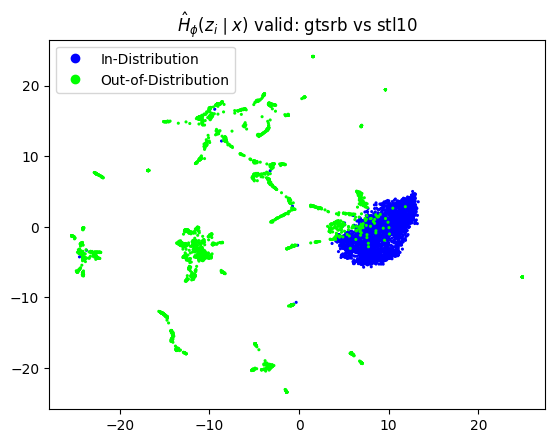

In [22]:
plot_samples_pacmap(gtsrb_rn18_h_z_stl10_valid_samples_np,
                    gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ valid: gtsrb vs stl10")

(9273, 128)
(9273, 1)
(9273, 2)


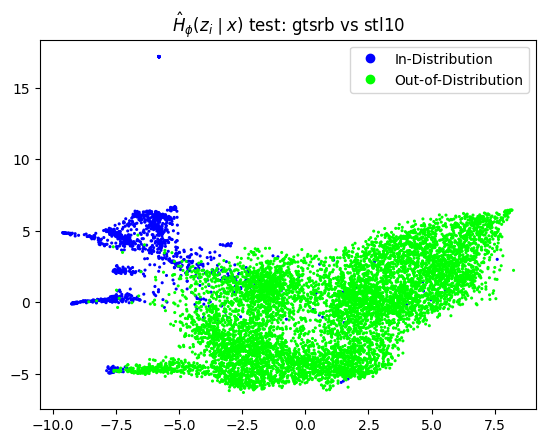

In [37]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np,
                    gtsrb_rn18_h_z_stl10_test_samples_np,
                    neighbors=16,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ test: gtsrb vs stl10")

(9273, 128)
(9273, 1)
(9273, 2)


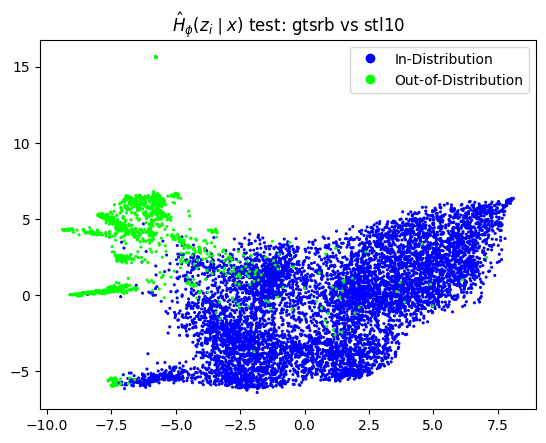

In [38]:
plot_samples_pacmap(gtsrb_rn18_h_z_stl10_test_samples_np,
                    gtsrb_rn18_h_z_gtsrb_normal_test_samples_np,
                    neighbors=16,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ test: gtsrb vs stl10")

# Raw Dataset

In [13]:
ic(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_test_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_test_samples_np.shape);

ic| gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_cifar10_valid_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_cifar10_test_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_stl10_valid_samples_np.shape: (3000, 128)
ic| gtsrb_rn18_h_z_stl10_test_samples_np.shape: (8000, 128)


## Build Detector

In [14]:
gtsrb_ds_shift_detector = DetectorKDE(train_embeddings=gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np)

## Get Scores

In [15]:
scores_gtsrb_valid = get_hz_scores(gtsrb_ds_shift_detector, gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np)
scores_gtsrb_test = get_hz_scores(gtsrb_ds_shift_detector, gtsrb_rn18_h_z_gtsrb_normal_test_samples_np)
scores_cifar10_valid = get_hz_scores(gtsrb_ds_shift_detector, gtsrb_rn18_h_z_cifar10_valid_samples_np)
scores_cifar10_test = get_hz_scores(gtsrb_ds_shift_detector, gtsrb_rn18_h_z_cifar10_test_samples_np)
scores_stl10_valid = get_hz_scores(gtsrb_ds_shift_detector, gtsrb_rn18_h_z_stl10_valid_samples_np)
scores_stl10_test = get_hz_scores(gtsrb_ds_shift_detector, gtsrb_rn18_h_z_stl10_test_samples_np)

In [16]:
gtsrb_ind_all = np.concatenate((scores_gtsrb_valid, scores_gtsrb_test))
cifar10_all = np.concatenate((scores_cifar10_valid, scores_cifar10_test))
stl10_all = np.concatenate((scores_stl10_valid, scores_stl10_test))

## Get Results

In [17]:
print("Ref. Dataset shape", gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
print("Test InD shape", scores_gtsrb_test.shape);
print("Test OoD shape", scores_stl10_valid.shape);

results_stl10_validation = get_hz_detector_results(detect_exp_name="gtsrb-test vs. stl10-validation",
                                                   ind_samples_scores=scores_gtsrb_test,
                                                   ood_samples_scores=scores_stl10_valid)

Ref. Dataset shape (3609, 128)
Test InD shape (1273,)
Test OoD shape (10000,)
AUROC: 0.9390
FPR95: 0.2827
AUPR: 0.7593


In [19]:
print("Ref. Dataset shape", gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
print("Test InD shape", scores_gtsrb_test.shape);
print("Test OoD shape", scores_stl10_test.shape);

results_stl10_test = get_hz_detector_results(detect_exp_name="gtsrb-test vs. stl10-test",
                                             ind_samples_scores=scores_gtsrb_test,
                                             ood_samples_scores=scores_stl10_test)

Ref. Dataset shape (3609, 128)
Test InD shape (1273,)
Test OoD shape (10000,)
AUROC: 0.9380
FPR95: 0.2853
AUPR: 0.7480


In [20]:
print("Ref. Dataset shape", gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
print("Test InD shape", scores_gtsrb_test.shape);
print("Test OoD shape", scores_cifar10_valid.shape);

results_cifar10_validation = get_hz_detector_results(detect_exp_name="gtsrb-test vs. cifar10-validation",
                                                     ind_samples_scores=scores_gtsrb_test,
                                                     ood_samples_scores=scores_cifar10_valid)

Ref. Dataset shape (3609, 128)
Test InD shape (1273,)
Test OoD shape (3000,)
AUROC: 0.9668
FPR95: 0.1490
AUPR: 0.9347


In [21]:
print("Ref. Dataset shape", gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
print("Test InD shape", scores_gtsrb_test.shape);
print("Test OoD shape", scores_cifar10_test.shape);

results_cifar10_test = get_hz_detector_results(detect_exp_name="gtsrb-test vs. cifar10-test",
                                             ind_samples_scores=scores_gtsrb_test,
                                             ood_samples_scores=scores_cifar10_test)

Ref. Dataset shape (3609, 128)
Test InD shape (1273,)
Test OoD shape (8000,)
AUROC: 0.9679
FPR95: 0.1474
AUPR: 0.8730


In [35]:
print("Ref. Dataset shape", gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
print("Test InD shape", scores_gtsrb_test.shape);
print("Test OoD shape", cifar10_all.shape);



results_cifar10_all_1 = get_hz_detector_results(detect_exp_name="gtsrb-test vs. cifar10-all",
                                             ind_samples_scores=scores_gtsrb_test,
                                             ood_samples_scores=cifar10_all)

Ref. Dataset shape (3609, 128)
Test InD shape (1273,)
Test OoD shape (11000,)
AUROC: 0.9676
FPR95: 0.1478
AUPR: 0.8433


In [36]:
print("Ref. Dataset shape", gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
print("Test InD shape", scores_gtsrb_test.shape);
print("Test OoD shape", stl10_all.shape);



results_stl10_all_1 = get_hz_detector_results(detect_exp_name="gtsrb-test vs. stl10-all",
                                             ind_samples_scores=scores_gtsrb_test,
                                             ood_samples_scores=stl10_all)

Ref. Dataset shape (3609, 128)
Test InD shape (1273,)
Test OoD shape (20000,)
AUROC: 0.9385
FPR95: 0.2840
AUPR: 0.6546


In [24]:
print("Ref. Dataset shape", gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
print("Test InD shape", gtsrb_ind_all.shape);
print("Test OoD shape", cifar10_all.shape);



results_cifar10_all_2 = get_hz_detector_results(detect_exp_name="gtsrb-test vs. cifar10-all",
                                             ind_samples_scores=gtsrb_ind_all,
                                             ood_samples_scores=cifar10_all)

Ref. Dataset shape (3609, 128)
Test InD shape (4882,)
Test OoD shape (11000,)
AUROC: 0.9916
FPR95: 0.0422
AUPR: 0.9859


In [25]:
print("Ref. Dataset shape", gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
print("Test InD shape", gtsrb_ind_all.shape);
print("Test OoD shape", stl10_all.shape);



results_stl10_all_2 = get_hz_detector_results(detect_exp_name="gtsrb-test vs. stl10-all",
                                             ind_samples_scores=gtsrb_ind_all,
                                             ood_samples_scores=stl10_all)

Ref. Dataset shape (3609, 128)
Test InD shape (4882,)
Test OoD shape (20000,)
AUROC: 0.9840
FPR95: 0.0993
AUPR: 0.9628


gtsrb-test vs. stl10-all


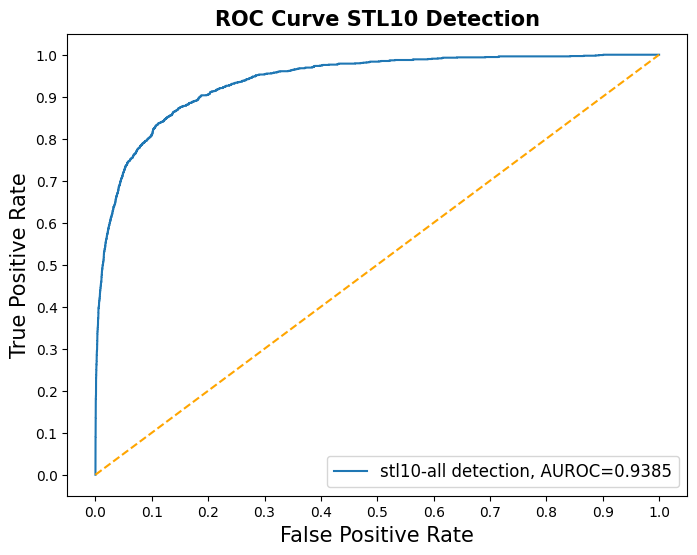

In [38]:
plot_roc_ood_detector(results_table=results_stl10_all_1,
                      legend_title="stl10-all detection",
                      plot_title="ROC Curve STL10 Detection")

gtsrb-test vs. stl10-all


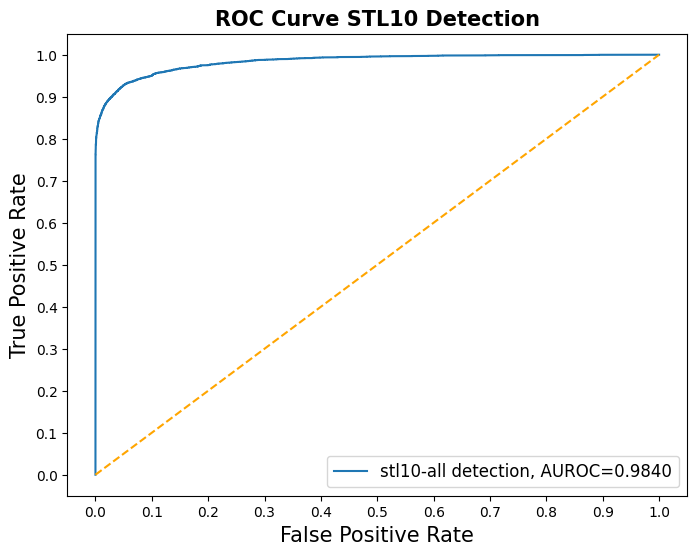

In [32]:
plot_roc_ood_detector(results_table=results_stl10_all_2,
                      legend_title="stl10-all detection",
                      plot_title="ROC Curve STL10 Detection")

gtsrb-test vs. cifar10-all


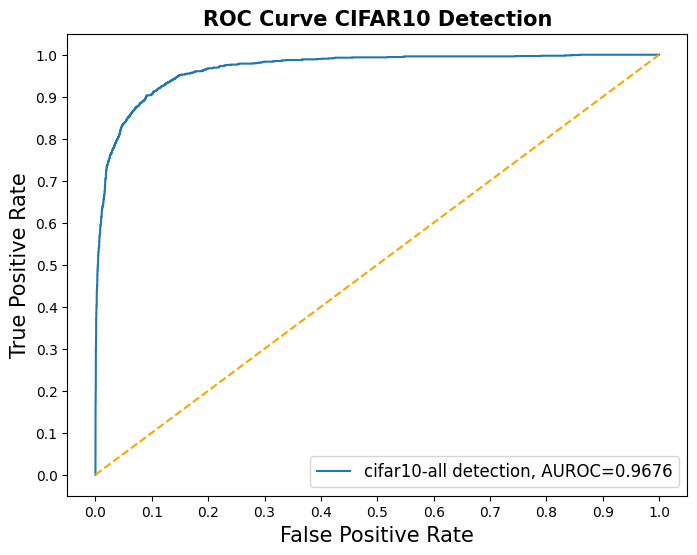

In [39]:
plot_roc_ood_detector(results_table=results_cifar10_all_1,
                      legend_title="cifar10-all detection",
                      plot_title="ROC Curve CIFAR10 Detection")

gtsrb-test vs. cifar10-all


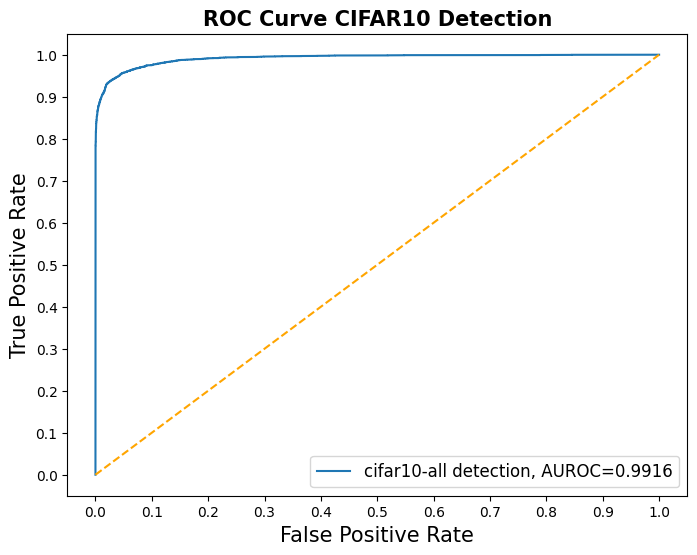

In [40]:
plot_roc_ood_detector(results_table=results_cifar10_all_2,
                      legend_title="cifar10-all detection",
                      plot_title="ROC Curve CIFAR10 Detection")

## Plot Score Values

In [ ]:
df_score_gtsrb_test = pd.DataFrame(scores_gtsrb_test, columns=["Entropy score"])
df_score_stl10_valid = pd.DataFrame(stl10_all[9500:10500], columns=["Entropy score"])
df_score_cifar10_valid = pd.DataFrame(cifar10_all[3500:4500], columns=["Entropy score"])

df_score_gtsrb_test.insert(0, "Dataset", "")
df_score_gtsrb_test.loc[:, "Dataset"] = "gtsrb"

df_score_stl10_valid.insert(0, "Dataset", "")
df_score_stl10_valid.loc[:, "Dataset"] = "stl10"

df_score_cifar10_valid.insert(0, "Dataset", "")
df_score_cifar10_valid.loc[:, "Dataset"] = "cifar10"

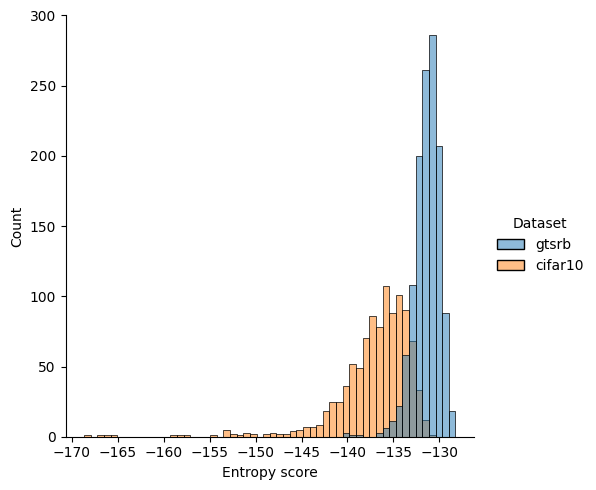

In [41]:
df_h_z_valid_scores = pd.concat([df_score_gtsrb_test,
                                 df_score_cifar10_valid]).reset_index(drop=True)
sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

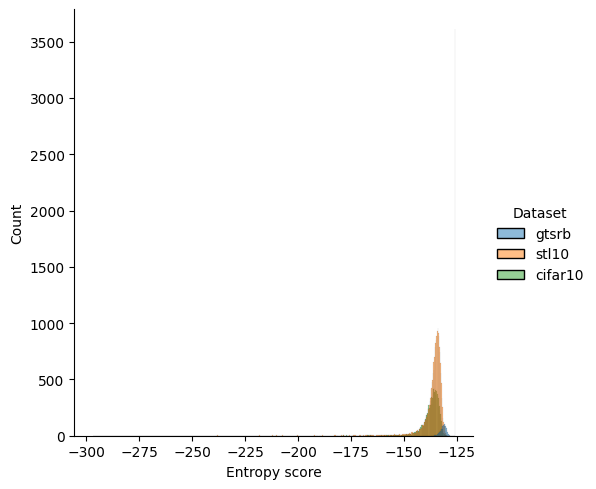

In [183]:
df_score_gtsrb_test = pd.DataFrame(gtsrb_ind_all, columns=["Entropy score"])
df_score_stl10_valid = pd.DataFrame(stl10_all, columns=["Entropy score"])
df_score_cifar10_valid = pd.DataFrame(cifar10_all, columns=["Entropy score"])

df_score_gtsrb_test.insert(0, "Dataset", "")
df_score_gtsrb_test.loc[:, "Dataset"] = "gtsrb"

df_score_stl10_valid.insert(0, "Dataset", "")
df_score_stl10_valid.loc[:, "Dataset"] = "stl10"

df_score_cifar10_valid.insert(0, "Dataset", "")
df_score_cifar10_valid.loc[:, "Dataset"] = "cifar10"

df_h_z_valid_scores = pd.concat([df_score_gtsrb_test, df_score_stl10_valid, df_score_cifar10_valid]).reset_index(drop=True)


sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

# PCA Dataset

## PCA Dimensionality Reduction

In [121]:
pca_h_z_gtsrb_normal_valid_samples, pca_tr = apply_pca_ds_split(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np, 32)
pca_h_z_gtsrb_normal_test_samples = apply_pca_transform(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np, pca_tr)
pca_h_z_stl10_valid_samples = apply_pca_transform(gtsrb_rn18_h_z_stl10_valid_samples_np, pca_tr)
pca_h_z_stl10_test_samples = apply_pca_transform(gtsrb_rn18_h_z_stl10_test_samples_np, pca_tr)
pca_h_z_cifar10_valid_samples = apply_pca_transform(gtsrb_rn18_h_z_cifar10_valid_samples_np, pca_tr)
pca_h_z_cifar10_test_samples = apply_pca_transform(gtsrb_rn18_h_z_cifar10_test_samples_np, pca_tr)

In [108]:
ic(pca_h_z_gtsrb_normal_valid_samples.shape);
ic(pca_h_z_stl10_valid_samples.shape);

ic| pca_h_z_gtsrb_normal_valid_samples.shape: (3609, 8)
ic| pca_h_z_stl10_valid_samples.shape: (3000, 8)


(6609, 8)
(6609, 1)
(6609, 2)


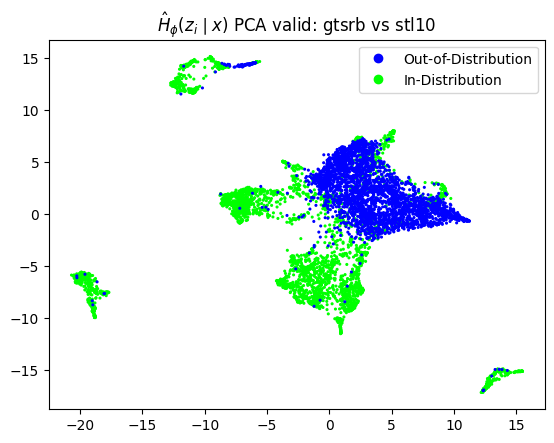

In [110]:
plot_samples_pacmap(pca_h_z_gtsrb_normal_valid_samples,
                    pca_h_z_stl10_valid_samples,
                    neighbors=16,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ PCA valid: gtsrb vs stl10")

## Build OoD Detector

In [111]:
ic(pca_h_z_gtsrb_normal_valid_samples.shape)
ic(pca_h_z_gtsrb_normal_test_samples.shape)
ic(pca_h_z_stl10_valid_samples.shape)
ic(pca_h_z_stl10_test_samples.shape)
ic(pca_h_z_cifar10_valid_samples.shape)
ic(pca_h_z_cifar10_test_samples.shape)

ic| pca_h_z_gtsrb_normal_valid_samples.shape: (3609, 8)
ic| pca_h_z_gtsrb_normal_test_samples.shape: (1273, 8)
ic| pca_h_z_stl10_valid_samples.shape: (3000, 8)
ic| pca_h_z_stl10_test_samples.shape: (8000, 8)
ic| pca_h_z_cifar10_valid_samples.shape: (10000, 8)
ic| pca_h_z_cifar10_test_samples.shape: (10000, 8)


(10000, 8)

In [112]:
gtsrb_ds_shift_detector = DetectorKDE(train_embeddings=pca_h_z_gtsrb_normal_valid_samples)

In [113]:
ic(gtsrb_ds_shift_detector.density);
ic(gtsrb_ds_shift_detector.kernel);

ic| gtsrb_ds_shift_detector.density: KernelDensity()
ic| gtsrb_ds_shift_detector.kernel: 'gaussian'


## Get Scores

In [ ]:
scores_gtsrb_test = get_hz_scores(gtsrb_ds_shift_detector, pca_h_z_gtsrb_normal_test_samples)
scores_stl10_valid = get_hz_scores(gtsrb_ds_shift_detector, pca_h_z_stl10_valid_samples)
scores_stl10_test = get_hz_scores(gtsrb_ds_shift_detector, pca_h_z_stl10_test_samples)
scores_cifar10_valid = get_hz_scores(gtsrb_ds_shift_detector, pca_h_z_cifar10_valid_samples)
scores_cifar10_test = get_hz_scores(gtsrb_ds_shift_detector, pca_h_z_cifar10_test_samples)

## Get Results

In [115]:
print("Ref. Dataset shape", pca_h_z_gtsrb_normal_valid_samples.shape);
print("Test InD shape", scores_gtsrb_test.shape);
print("Test OoD shape", scores_stl10_valid.shape);

results_stl10_validation = get_hz_detector_results(detect_exp_name="gtsrb-test vs. stl10-validation",
                                                   ind_samples_scores=scores_gtsrb_test,
                                                   ood_samples_scores=scores_stl10_valid)

Ref. Dataset shape (3609, 8)
Test InD shape (1273,)
Test OoD shape (3000,)
AUROC: 0.8221
FPR95: 0.5427
AUPR: 0.6559


In [116]:
print("Ref. Dataset shape", pca_h_z_gtsrb_normal_valid_samples.shape);
print("Test InD shape", scores_gtsrb_test.shape);
print("Test OoD shape", scores_stl10_test.shape);

results_stl10_test = get_hz_detector_results(detect_exp_name="gtsrb-test vs. stl10-test",
                                             ind_samples_scores=scores_gtsrb_test,
                                             ood_samples_scores=scores_stl10_test)

Ref. Dataset shape (3609, 8)
Test InD shape (1273,)
Test OoD shape (8000,)
AUROC: 0.8275
FPR95: 0.5387
AUPR: 0.4565


In [117]:
print("Ref. Dataset shape", pca_h_z_gtsrb_normal_valid_samples.shape);
print("Test InD shape", scores_gtsrb_test.shape);
print("Test OoD shape", scores_cifar10_valid.shape);

results_cifar10_validation = get_hz_detector_results(detect_exp_name="gtsrb-test vs. cifar10-validation",
                                                     ind_samples_scores=scores_gtsrb_test,
                                                     ood_samples_scores=scores_cifar10_valid)

Ref. Dataset shape (3609, 8)
Test InD shape (1273,)
Test OoD shape (10000,)
AUROC: 0.7926
FPR95: 0.5908
AUPR: 0.3407


In [118]:
print("Ref. Dataset shape", pca_h_z_gtsrb_normal_valid_samples.shape);
print("Test InD shape", scores_gtsrb_test.shape);
print("Test OoD shape", scores_cifar10_test.shape);

results_cifar10_test = get_hz_detector_results(detect_exp_name="gtsrb-test vs. cifar10-test",
                                             ind_samples_scores=scores_gtsrb_test,
                                             ood_samples_scores=scores_cifar10_test)

Ref. Dataset shape (3609, 8)
Test InD shape (1273,)
Test OoD shape (10000,)
AUROC: 0.7950
FPR95: 0.5860
AUPR: 0.3535


gtsrb-test vs. stl10-validation


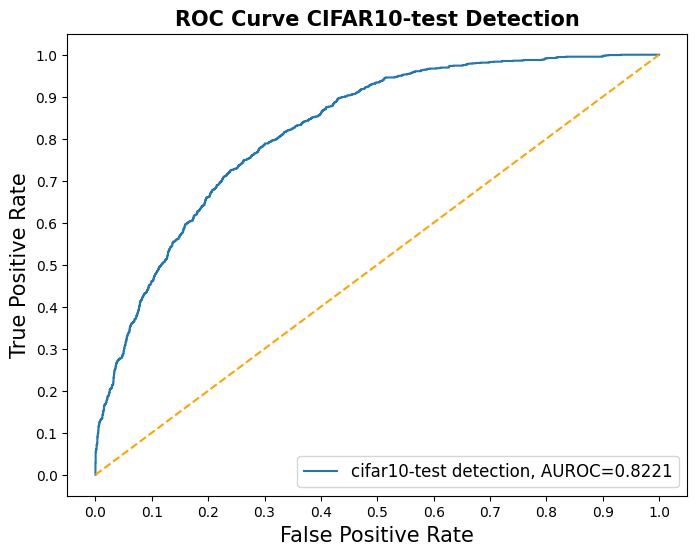

In [124]:
plot_roc_ood_detector(results_table=results_stl10_validation,
                      legend_title="cifar10-test detection",
                      plot_title="ROC Curve CIFAR10-test Detection")

gtsrb-test vs. cifar10-test


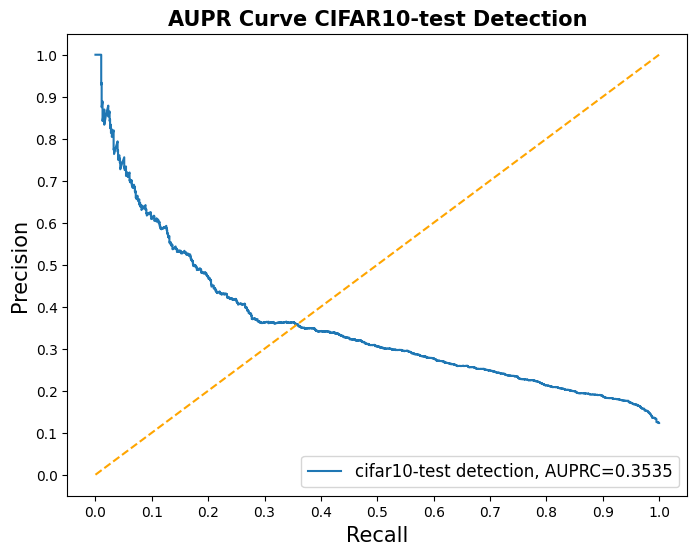

In [120]:
plot_auprc_ood_detector(results_table=results_cifar10_test,
                        legend_title="cifar10-test detection",
                        plot_title="AUPR Curve CIFAR10-test Detection")

In [47]:
results_cifar10_test

,auroc,fpr@95,aupr,fpr,tpr,roc_thresholds,precision,recall,pr_thresholds
experiment,,,,,,,,,
gtsrb-test vs. cifar10-test,tensor(0.9980),tensor(0.0025),0.943618,"[tensor(0.), tensor(1.0000e-04), tensor(0.0002...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(1.0465, dtype=torch.float64), tensor(0...","[tensor(0.9762), tensor(0.9762), tensor(0.9770...","[tensor(1.), tensor(0.9992), tensor(0.9992), t...","[tensor(0.0251, dtype=torch.float64), tensor(0..."


## Plot Score values

In [29]:
ic(scores_gtsrb_test.shape);

ic(scores_stl10_valid.shape);
ic(scores_cifar10_valid.shape);

ic(scores_stl10_test.shape);
ic(scores_cifar10_test.shape);

ic| scores_gtsrb_test.shape: (1273,)
ic| scores_stl10_valid.shape: (3000,)
ic| scores_cifar10_valid.shape: (10000,)
ic| scores_stl10_test.shape: (8000,)
ic| scores_cifar10_test.shape: (10000,)


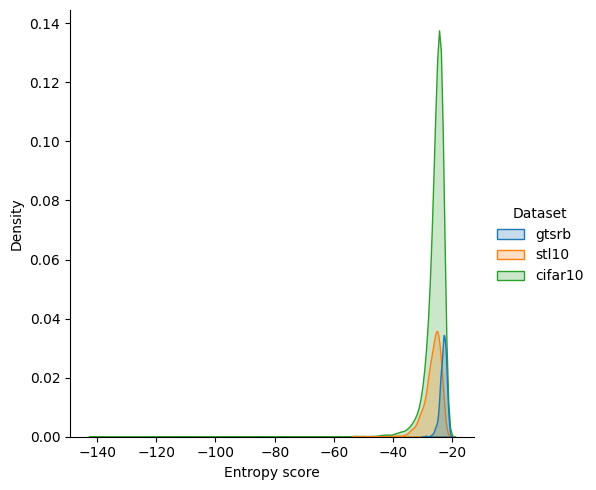

In [30]:
df_score_gtsrb_test = pd.DataFrame(scores_gtsrb_test, columns=["Entropy score"])
df_score_stl10_valid = pd.DataFrame(scores_stl10_valid, columns=["Entropy score"])
df_score_cifar10_valid = pd.DataFrame(scores_cifar10_valid, columns=["Entropy score"])

df_score_gtsrb_test.insert(0, "Dataset", "")
df_score_gtsrb_test.loc[:, "Dataset"] = "gtsrb"

df_score_stl10_valid.insert(0, "Dataset", "")
df_score_stl10_valid.loc[:, "Dataset"] = "stl10"

df_score_cifar10_valid.insert(0, "Dataset", "")
df_score_cifar10_valid.loc[:, "Dataset"] = "cifar10"

df_h_z_valid_scores = pd.concat([df_score_gtsrb_test, df_score_stl10_valid, df_score_cifar10_valid]).reset_index(drop=True)


sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="kde", fill=True)
plt.show()

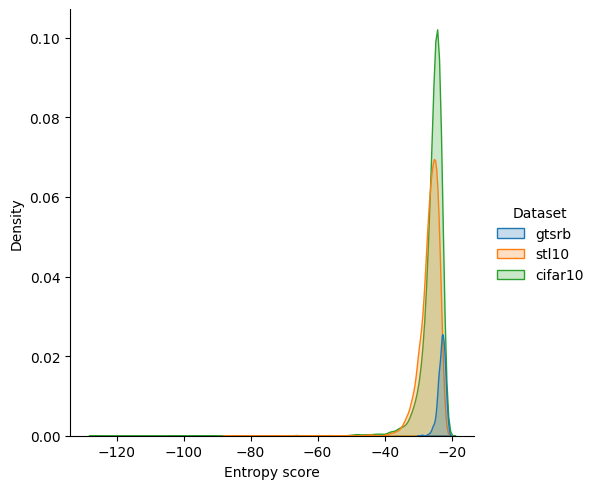

In [31]:
df_score_gtsrb_test = pd.DataFrame(scores_gtsrb_test, columns=["Entropy score"])
df_score_stl10_test = pd.DataFrame(scores_stl10_test, columns=["Entropy score"])
df_score_cifar10_test = pd.DataFrame(scores_cifar10_test, columns=["Entropy score"])

df_score_gtsrb_test.insert(0, "Dataset", "")
df_score_gtsrb_test.loc[:, "Dataset"] = "gtsrb"

df_score_stl10_test.insert(0, "Dataset", "")
df_score_stl10_test.loc[:, "Dataset"] = "stl10"

df_score_cifar10_test.insert(0, "Dataset", "")
df_score_cifar10_test.loc[:, "Dataset"] = "cifar10"

df_h_z_test_scores = pd.concat([df_score_gtsrb_test, df_score_stl10_test, df_score_cifar10_test]).reset_index(drop=True)


sns.displot(df_h_z_test_scores, x="Entropy score", hue="Dataset", kind="kde", fill=True)
plt.show()

# Raw Dataset - Train Data Reference

In [14]:
ic(gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_test_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_test_samples_np.shape);

ic| gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape: (7120, 128)
ic| gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_cifar10_valid_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_cifar10_test_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_stl10_valid_samples_np.shape: (3000, 128)
ic| gtsrb_rn18_h_z_stl10_test_samples_np.shape: (8000, 128)


In [17]:
gtsrb_h_z = np.concatenate((gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np, gtsrb_rn18_h_z_gtsrb_normal_test_samples_np))
cifar10_h_z = np.concatenate((gtsrb_rn18_h_z_cifar10_valid_samples_np, gtsrb_rn18_h_z_cifar10_test_samples_np))
stl10_h_z = np.concatenate((gtsrb_rn18_h_z_stl10_valid_samples_np, gtsrb_rn18_h_z_stl10_test_samples_np))

## Build Detector

In [16]:
gtsrb_ds_shift_detector = DetectorKDE(train_embeddings=gtsrb_rn18_h_z_gtsrb_normal_train_samples_np)

## Get Scores

In [18]:
scores_gtsrb = get_hz_scores(gtsrb_ds_shift_detector, gtsrb_h_z)

scores_cifar10 = get_hz_scores(gtsrb_ds_shift_detector, cifar10_h_z)

scores_stl10 = get_hz_scores(gtsrb_ds_shift_detector, stl10_h_z)


## Get Results

In [19]:
print("Test InD shape", scores_gtsrb.shape);
print("Test OoD shape", scores_stl10.shape);

results_stl10_validation = get_hz_detector_results(detect_exp_name="gtsrb vs. stl10",
                                                   ind_samples_scores=scores_gtsrb,
                                                   ood_samples_scores=scores_stl10)

Test InD shape (4882,)
Test OoD shape (20000,)
AUROC: 0.9258
FPR95: 0.3576
AUPR: 0.8057


In [20]:
print("Test InD shape", scores_gtsrb.shape);
print("Test OoD shape", scores_cifar10.shape);

results_cifar10_validation = get_hz_detector_results(detect_exp_name="gtsrb vs. cifar10",
                                                     ind_samples_scores=scores_gtsrb,
                                                     ood_samples_scores=scores_cifar10)

Test InD shape (4882,)
Test OoD shape (11000,)
AUROC: 0.9593
FPR95: 0.2002
AUPR: 0.9261


## Plot Score Values

In [21]:
df_scores_gtsrb = pd.DataFrame(scores_gtsrb, columns=["Entropy score"])
df_scores_stl10 = pd.DataFrame(scores_stl10, columns=["Entropy score"])
df_scores_cifar10 = pd.DataFrame(scores_cifar10, columns=["Entropy score"])

df_scores_gtsrb.insert(0, "Dataset", "")
df_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_scores_stl10.insert(0, "Dataset", "")
df_scores_stl10.loc[:, "Dataset"] = "stl10"

df_scores_cifar10.insert(0, "Dataset", "")
df_scores_cifar10.loc[:, "Dataset"] = "cifar10"

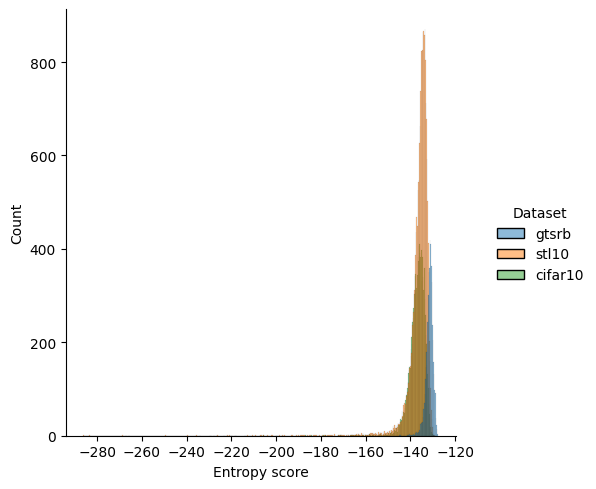

In [22]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_stl10,
                                 df_scores_cifar10]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

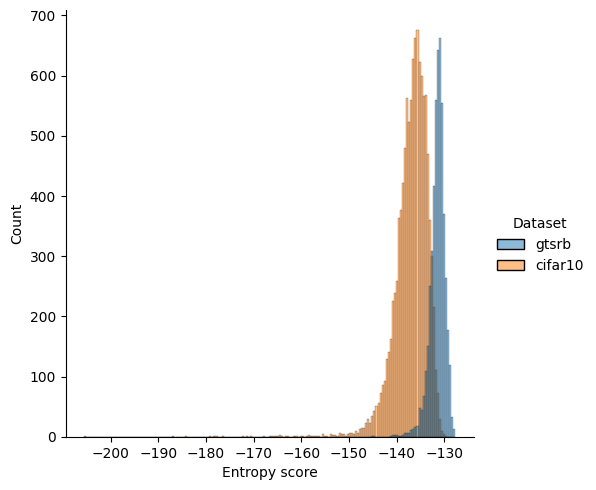

In [23]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_cifar10]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

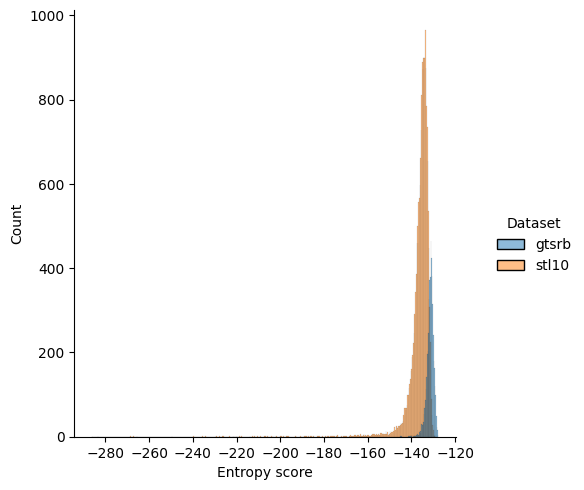

In [24]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_stl10]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()